# AEROSP 520 Compressible Flow: Homework 3
Jason Chen

## Problem 1
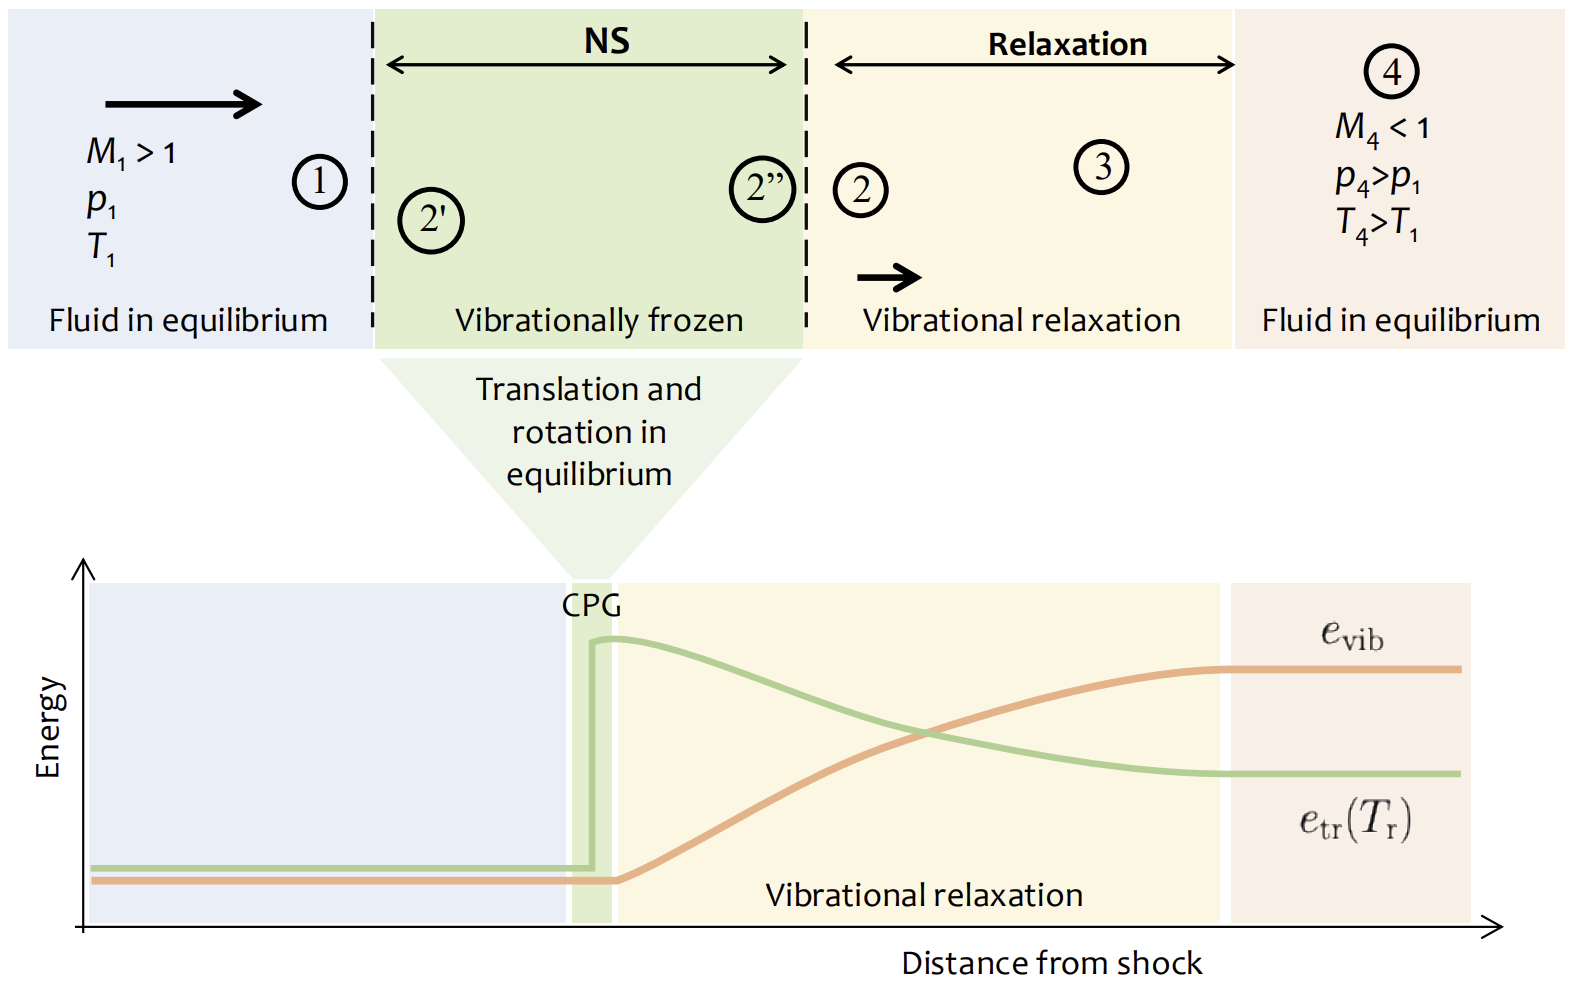
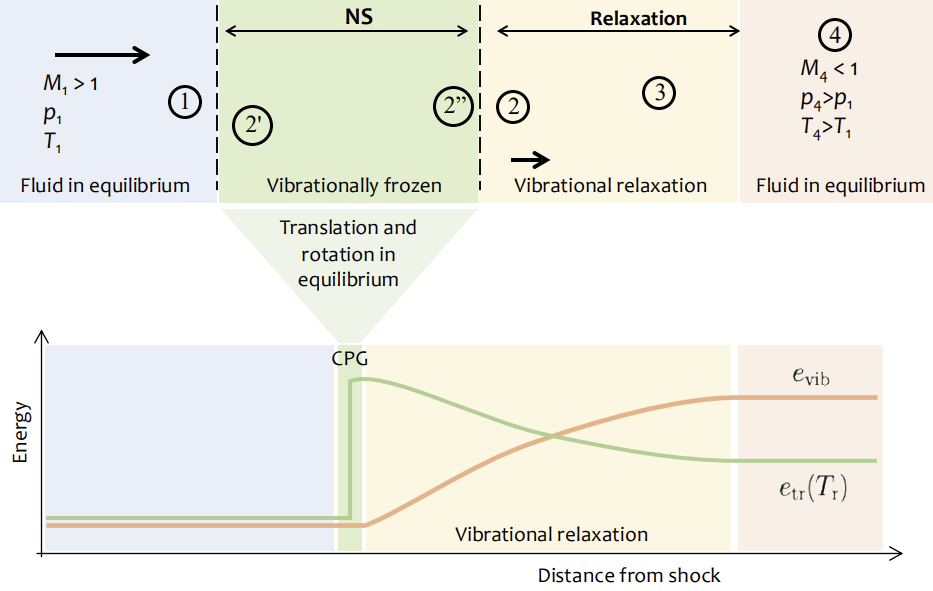

In this problem, we're asked to model the relaxation region after a normal shock using the continuity equations and the relaxation timescale model as proposed by Millikan and White (1963). The continuity equations in differential form are:
$$
\rho \frac{du}{dx} + u \frac{d\rho}{dx} = 0
$$
$$
\frac{dp}{dx} + \rho u \frac{du}{dx} = 0
$$
$$
\frac{dh}{dx} - \frac{1}{\rho} \frac{dp}{dx} = \frac{d(h^{*}+\frac{1}{2}u^2)}{dx} + \frac{d e_{vib}}{dx} = 0
$$
Enthalpy by definition is:
$$
h = e_{tr} + e_{rot} + e_{vib} + RT 
$$
For the vibrationally frozen enthalpy and given that our mixture is made of linear diatomic molecules:
$$
h^{*} = e^{*} + pv = e_{tr} + e_{rot} + RT = \frac{3}{2}RT + \frac{2}{2}RT + RT = \frac{7}{2}RT
$$
The Landau-Teller model for vibrational relaxation when applied to a 1D steady problem (re-expressed using the total derivative as shown in lecture) is:
$$
u \frac{d e_{vib}}{dx} = - \frac{e_{vib} - e^{*}_{vib}}{\tau_v(p, T)}
$$
where $e_{vib}$ is the actual amount of energy in the vibrational mode, $e^{*}_{vib}$ is the apparent vibrational energy (if evaluated at the local temperature, $T_{tr}$):
$$
e^{*}_{vib}(T_{tr}) = \frac{R\Theta_v}{e^{\Theta_v/T_r}-1}
$$
$\tau_v$ is the timescale from Millikan and White. The result of the Millikan and White paper is an empirically derived relationship:
$$
\ln(p\tau_v) = \left( 1.16 \times 10^{-3} \right) \mu^{\frac{1}{2}} \Theta_v^{\frac{4}{3}} \left( T^{-\frac{1}{3}} - 0.015\mu^{\frac{1}{4}} \right) - 18.42
$$
where $\mu$ is the reduced mass of the colliding pair, which given each has a molecular mass $m_1$ and $m_2$:
$$
\mu = \frac{m_1 m_2}{m_1 + m_2}
$$
$\Theta_v$ is the characteristic vibrational temperature, representing the quantum spacing of an internal mode (like vibration). For example: $\Theta_v = 3390 \textrm{ K}$ for $N_2$ and $\Theta_v = 2270 \textrm{ K}$ for $O_2$. Combining the energy equations:
$$
\left(
\frac{5}{2}u - \frac{7}{2}RT_{\mathrm{tr}}
\right)
\frac{du}{dx}
=
\sum_{i=1}^{N}
y_i\,
\frac{
e^{*}_{\mathrm{vib},i}(T_{\mathrm{tr}})
-
e_{\mathrm{vib},i}
}{
u\,\bar{\tau_i}(p,T)
}
$$
where $y_i$ is the mass fraction of species $i$ in the mixture.
The problem statement tells us to perform this relaxation assuming the medium is air, which is 21% $O_2$ and 79% $N_2$ by volume. This means that all possible collisions are between $O_2$-$O_2$, $N_2$-$N_2$, and $N_2$-$O_2$, and these processes occur at different rates. So for a species colliding with all possible partners, we can define an average relaxation time $\bar{\tau_i}$:
$$
\frac{1}{\bar{\tau_i}} = \sum_{j=1}^{N}{\frac{X_i}{\tau_{i-j}}}
$$
We will use the first order upwind finite difference scheme to break up the differentials:
$$
\frac{d\phi}{dx} = \frac{\phi_{k+1} - \phi_{k}}{\Delta x}
$$
This means that, for example, the Landau-Teller equation can be rewritten as:
$$
e_{vib,i,k+1} = \left(\frac{e^{*}_{vib,i,k} - e_{vib,i,k}}{u \tau_i(p, T)}\right) \Delta x + e_{vib,i,k}
$$

Thus, we can solve the problem in this order:
1. Use Landau-Teller for each species to find the new $e_{vib}$ at state $k+1$ (we know the initial vibrational energy postshock from the preshock condition, since the mode is frozen across the NS)
2. Get $\bar{\tau}$ for each species as a function of its collisions with other species
3. Solve numerically for the new velocity $u_{k+1}$
4. Use continuity to solve for $\rho_{k+1}$
5. Use continuity to solve for $p_{k+1}$


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# First, establish mass fractions, mole fractions, and mixture properties
x_O2 = 0.21
x_N2 = 0.79
M_O2 = 32.00e-3
M_N2 = 28.01e-3
M_mix = x_O2 * M_O2 + x_N2 * M_N2
# Mass fractions
y_O2 = x_O2 * M_O2 / M_mix
y_N2 = x_N2 * M_N2 / M_mix
R_univ = 8.3145
R_O2 = R_univ / M_O2
R_N2 = R_univ / M_N2
R_mix = R_univ / M_mix
gamma_star = 7/5
theta_v_O2 = 2270
theta_v_N2 = 3390
mu_O2, mu_N2 = 16, 14
mu_N2_O2 = (mu_N2 * mu_O2) / (mu_N2 + mu_O2)

def get_thermalized_e_vib(theta_v, R, T_v):
    return (theta_v * R)/(np.exp(theta_v/T_v) - 1)

def get_tau_i_j(T_tr, p, mu, theta_v):
    return (np.exp(1.16e-3 * mu**(1/2) * theta_v**(4/3) * (T_tr**(-1/3) - 0.015 * mu**(1/4)) - 18.42)) / (p/101325)

def solve_relaxation(M1, end_x, dx=2e-7):
    # Inlet conditions
    p1 = 1.2e3
    T1 = 227
    a1 = np.sqrt(gamma_star * R_mix * T1)
    u1 = M1 * a1
    rho1 = p1 / (R_mix * T1)
    # Across the NS, vibrationally frozen, equilibrium translational and rotational modes
    p2 = p1 * (1 + 2 * gamma_star * (M1**2 - 1)/(gamma_star + 1))
    rho2 = rho1 * ((gamma_star+1) * M1**2)/(2 + (gamma_star-1) * M1**2)
    u2 = u1 * (2 + (gamma_star - 1) * M1**2) / ((gamma_star + 1) * M1**2)
    T2 = p2 / (rho2 * R_mix)
    # Set up data collection
    x_range = np.arange(0, end_x, dx)
    e_vib_o2 = np.zeros(len(x_range))
    e_vib_n2 = np.zeros(len(x_range))
    e_vib_mix = np.zeros(len(x_range))
    u = np.zeros(len(x_range))
    rho = np.zeros(len(x_range))
    p = np.zeros(len(x_range))
    T = np.zeros(len(x_range))
    # Input initial conditions
    e_vib_o2[0] = get_thermalized_e_vib(theta_v_O2, R_O2, T1)
    e_vib_n2[0] = get_thermalized_e_vib(theta_v_N2, R_N2, T1)
    e_vib_mix[0] = e_vib_o2[0] * y_O2 + e_vib_n2[0] * y_N2
    u[0], rho[0], p[0], T[0] = u2, rho2, p2, T2
    for i in range(1, len(x_range)):
        T_prev, p_prev = T[i-1], p[i-1]
        # Get relaxation rates at the current temperature
        tau_o2_o2 = get_tau_i_j(T_prev, p_prev, mu_O2, theta_v_O2)
        tau_o2_n2 = get_tau_i_j(T_prev, p_prev, mu_N2_O2, theta_v_O2)
        tau_bar_o2 = (x_O2/tau_o2_o2 + x_N2/tau_o2_n2)**-1
        tau_n2_n2 = get_tau_i_j(T_prev, p_prev, mu_N2, theta_v_N2)
        tau_n2_o2 = get_tau_i_j(T_prev, p_prev, mu_N2_O2, theta_v_N2)
        tau_bar_n2 = (x_N2/tau_n2_n2 + x_O2/tau_n2_o2)**-1
        # Compute new vibrational energies using Landau-Teller and forward Euler integration
        e_vib_star_o2 = get_thermalized_e_vib(theta_v_O2, R_O2, T_prev)
        e_vib_o2[i] = ((e_vib_star_o2 - e_vib_o2[i-1])/(u[i-1] * tau_bar_o2)) * dx + e_vib_o2[i-1]
        e_vib_star_n2 = get_thermalized_e_vib(theta_v_N2, R_N2, T_prev)
        e_vib_n2[i] = ((e_vib_star_n2 - e_vib_n2[i-1])/(u[i-1] * tau_bar_n2)) * dx + e_vib_n2[i-1]
        e_vib_mix[i] = e_vib_o2[i] * y_O2 + e_vib_n2[i] * y_N2
        rhs_rate_o2 = ((e_vib_star_o2 - e_vib_o2[i-1])/(u[i-1] * tau_bar_o2)) * y_O2
        rhs_rate_n2 = ((e_vib_star_n2 - e_vib_n2[i-1])/(u[i-1] * tau_bar_n2)) * y_N2
        du_dx = (rhs_rate_o2 + rhs_rate_n2)/((5/2)*u[i-1] - (7/2)*R_mix*T_prev)
        # Integrate forwards to get new flow velocity
        u[i] = du_dx * dx + u[i-1]
        rho[i] = (-(rho[i-1]/u[i-1]) * du_dx) * dx + rho[i-1]
        p[i] = (-(rho[i-1]*u[i-1]) * du_dx) * dx + p[i-1]
        T[i] = p[i] / (rho[i] * R_mix)
    return x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2

data = solve_relaxation(M1=10, end_x=0.01)
x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2 = data
T_norm = 1+(np.divide(T, T2)-1)*5e2
p_norm = 1+(np.divide(p, p2)-1)*5e2
u_norm = 1+(np.divide(u, u2)-1)*5e2


### Part (a)
The numerical solution was found above, such that if we define equilibrium after the shock as once $e_{vib}$ reaches 1% of its equilibrium value, we see that:

In [57]:
print('Relaxation equilibrium solution:')
print(f'Temperature: {T_norm[-1]*T2:.2f} K | Pressure: {p_norm[-1]*p2:.1f} Pa | Velocity: {u_norm[-1]*u2:.2f} m/s')
print('CPG solution:')
print(f'Temperature: {T2:.2f} K | Pressure: {p2:.1f} Pa | Velocity: {u2:.2f} m/s')

Relaxation equilibrium solution:
Temperature: 3948.78 K | Pressure: 145263.1 Pa | Velocity: 431.22 m/s
CPG solution:
Temperature: 4627.96 K | Pressure: 139800.0 Pa | Velocity: 529.63 m/s


## Part (b)
Find the relaxation region length $\Delta x$ defined as the length from the normal shock required for the vibrational
energy to be within 1% of its final equilibrium value. Plot $\Delta x$ as a function of $M_1$ for the given initial
conditions in the range $1 < M_1 < 10$.

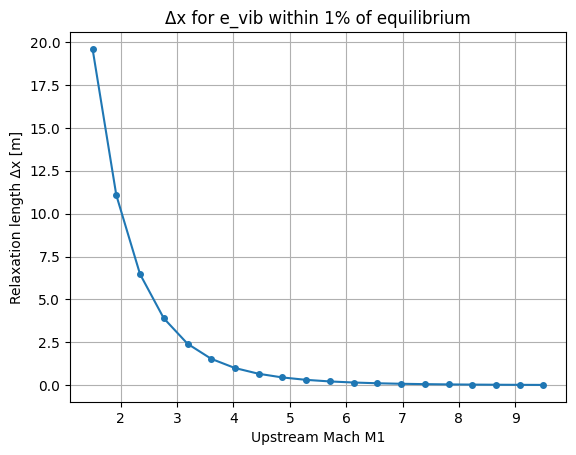

In [58]:
n = 20
end_x = 50
dx = 1e-4
delta_x_list = np.zeros(n)

for k, M in enumerate(np.linspace(4.5, 9.5, n)):
    x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2 = solve_relaxation(M, end_x, dx=dx)
    # Threshold: within 1% of equilibrium
    tol = 0.01 * np.abs(e_vib_mix[-1])
    # Find first index where mixture vibrational energy is within tolerance
    idx = np.where(np.abs(e_vib_mix - e_vib_mix[-1]) <= tol)[0]
    delta_x = x_range[idx[0]]
    # print(f'Mach {M:.2f} | Relaxation length Δx = {delta_x*1e3:.1f} mm')
    delta_x_list[k] = delta_x

plt.figure()
plt.plot(np.linspace(1.5, 9.5, n), delta_x_list, '-o', markersize=4)
plt.xlabel('Upstream Mach M1')
plt.ylabel('Relaxation length Δx [m]')
plt.title('Δx for e_vib within 1% of equilibrium')
plt.grid(True)
plt.show()

### Part (c)

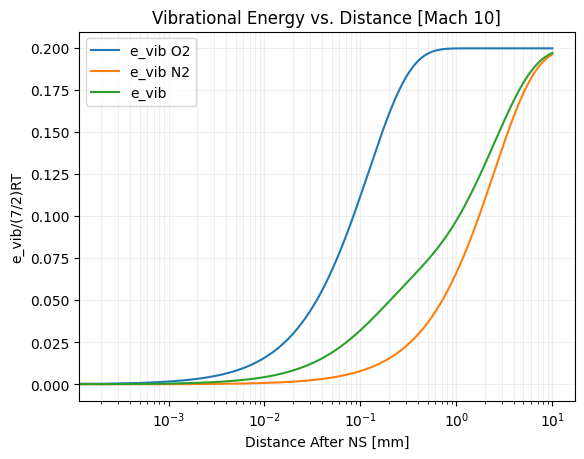

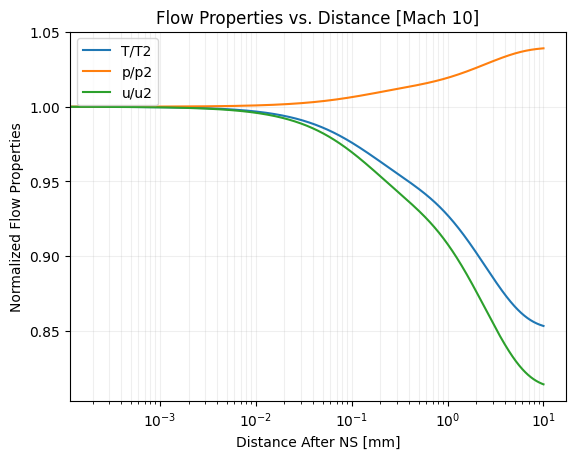

In [59]:
data = solve_relaxation(M1=10, end_x=0.01)
x_range, e_vib_o2, e_vib_n2, e_vib_mix, u, rho, p, T, T2, p2, u2 = data

plt.figure()
plt.plot(x_range * 1e3, np.divide(e_vib_o2, (7/2)*R_mix*T), linewidth=1.5, label='e_vib O2')
plt.plot(x_range * 1e3, np.divide(e_vib_n2, (7/2)*R_mix*T), linewidth=1.5, label='e_vib N2')
plt.plot(x_range * 1e3, np.divide(e_vib_mix, (7/2)*R_mix*T), linewidth=1.5, label='e_vib')
plt.xscale('log')
plt.xlabel('Distance After NS [mm]')
plt.ylabel('e_vib/(7/2)RT')
plt.title('Vibrational Energy vs. Distance [Mach 10]')
plt.legend()
plt.grid(which='both', axis='both', linestyle='-', alpha=0.2)
plt.show()

plt.figure()
plt.plot(x_range * 1e3, T_norm, linewidth=1.5, label='T/T2')
plt.plot(x_range * 1e3, p_norm, linewidth=1.5, label='p/p2')
plt.plot(x_range * 1e3, u_norm, linewidth=1.5, label='u/u2')
plt.xscale('log')
plt.xlabel('Distance After NS [mm]')
plt.ylabel('Normalized Flow Properties')
plt.title('Flow Properties vs. Distance [Mach 10]')
plt.legend()
plt.grid(which='both', axis='both', linestyle='-', alpha=0.2)
plt.show()

### Part (d)

We can see pretty clearly that the equilibrium distance changes exponentially with decreasing Mach number, meaning that at lower Mach numbers the relaxation distance is large and therefore we must model the process instead of treating it like a CPG. Fortunately, because the strength of the shock (and therefore change in state properties relative to the postshock CPG jump relations) is inversely related to the equilibrium distance, it means that a CPG solution is "less off" for lower Mach numbers.

To answer the question when does vibrational non-equilibrium become important: it really depends. At low Mach numbers while still in the bulk of the atmosphere, the difference in state variables computed will not necessarily affect vehicle design in a major way (imagine a Mach 2 passenger airliner). However for high hypersonics (e.g. on re-entry), the relaxation process is very important since the process evolves over the course of tens of millimeters, which can still affect heat sheilding and inlet design.

## Problem 2
We're given a nozzle contour:
$$
D(x) = \sqrt{1+0.25(x-3)^2}
$$
And asked to solve the general 1D flow solution in three cases:
1. Frictionless, no mass flow, adiabatic
2. $C_f = 0.01$, no mass flow, adiabatic
3. $C_f = 0.01$, no mass flow, $T_0(x) = 1000 + 10x \textrm{ [K]}$

The upstream stagnation conditions are known $T_0 = 1000 \textrm{ K}$ and $p_0 = 2 \textrm{ MPa}$, and known CPG quantities. We know the generalized ODE is:
$$
\boxed{\frac{1}{M^2}\frac{dM^2}{dx} = \frac{\psi G(x, \gamma, M)}{1-M^2}}
$$
where:
$$
\psi = 1+\frac{\gamma-1}{2} M^2
$$
and
$$
G(x, \gamma, M) = -2\frac{1}{A}\frac{dA}{dx} + \gamma M^2 \frac{4f}{D} + (1+\gamma M^2)\frac{1}{T_0}\frac{dT_0}{dx} + 2(1+\gamma M^2)\frac{1}{\dot{m}}\frac{d\dot{m}}{dx}
$$

### Part (a)
*Determine the sonic point location for each case if it exists.*

As outlined in the Hodge (1991) paper, the generalized analysis procedure will be to first find the driving potentials as a function of $x$. These are:
- Area change:
$$
A(x) = \pi D(x)^2 / 4 = \frac{\pi}{4} \left(1+0.25(x-3)^2\right)
$$
$$
\frac{1}{A}\frac{dA}{dx} = \frac{x-3}{2[1+0.25(x-3)^2]}
$$
- Heat addition:
$$
\frac{1}{T_0}\frac{dT_0}{dx} = \frac{10}{1000 + 10x}
$$
- Friction:
$$
\frac{4f}{D} = \frac{0.04}{\sqrt{1+0.25(x-3)^2}}
$$
Mass flow is zero for all cases so is not considered here. To evaluate the sonic point, we want to find where:
$$
\boxed{0 = G(x, \gamma, M=1)}
$$
And therefore solve in each case:
$$
0 = -2\frac{x-3}{2[1+0.25(x-3)^2]} + \gamma M^2 \frac{0.04}{\sqrt{1+0.25(x-3)^2}} + (1+\gamma M^2)\frac{10}{1000 + 10x}
$$
for $\gamma = 1.4$ and $M = 1$.

In [60]:
def solve_sonic_point(A: bool, B: bool, C: bool, gamma, M=1):
    """
    Let A, B, C be coefficients in front of the area, friction, and heat change terms
    such that we can customize what driving functions are active for each case
    """
    def g_function(x):
        area = A * -2 * ((x-3)/(2*(1 + 0.25 * ((x-3)**2))))
        friction = B * (gamma*(M**2)) * (0.04/np.sqrt(1 + 0.25 * ((x-3)**2)))
        heat = C * (1+(gamma*(M**2))) * (10/(1000 + (10*x)))
        return area + friction + heat
    # Guess at the minimum area point, which is x=3
    init_guess = 3
    return fsolve(g_function, x0=init_guess)[0]

case_1_sonic = solve_sonic_point(A=True, B=False, C=False, gamma=1.4)
case_2_sonic = solve_sonic_point(A=True, B=True, C=False, gamma=1.4)
case_3_sonic = solve_sonic_point(A=True, B=True, C=True, gamma=1.4)
print(f'Case 1 sonic point: x = {case_1_sonic:.4f} m')
print(f'Case 2 sonic point: x = {case_2_sonic:.4f} m')
print(f'Case 3 sonic point: x = {case_3_sonic:.4f} m')

Case 1 sonic point: x = 3.0000 m
Case 2 sonic point: x = 3.0560 m
Case 3 sonic point: x = 3.0794 m


### Part (b)
We're asked to find the distribution of Mach number and other properties along the nozzle. To do this, we follow Hodge's procedure, where we find the value of $dM/dx$ at the sonic point via:
$$
\frac{dM}{dx} = \frac{-b \pm \sqrt{b^2 - 4c}}{2}
$$
where $b$ and $c$ are long functions given in the paper that are not repeated here. We then numerically integrate backwards using the positive root found above to get the Mach number profile before the sonic point, and integrate forwards using the negative root to get the remaining profile. The other properties can be found using the integral relations:

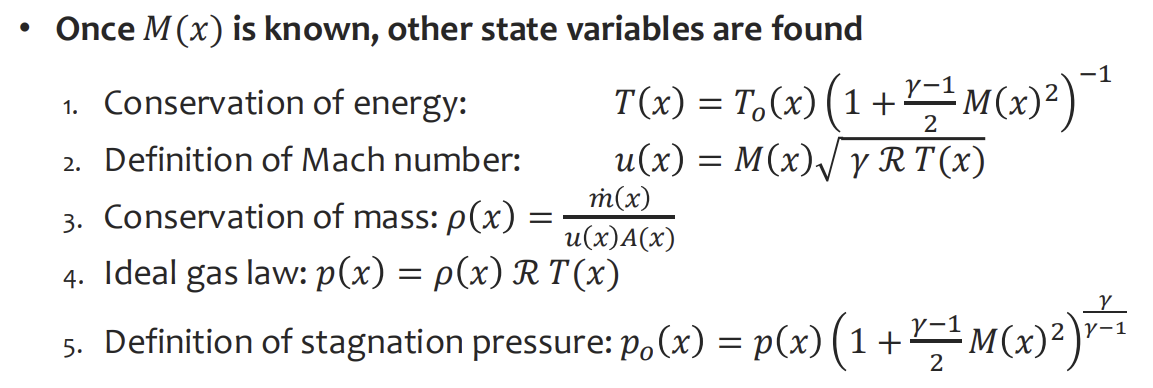

Note that since (excluding mass flow rate)
$$
G(x, \gamma, M) = -2\frac{1}{A}\frac{dA}{dx} + \gamma M^2 \frac{4f}{D} + (1+\gamma M^2)\frac{1}{T_0}\frac{dT_0}{dx}
$$
then
$$
\frac{d}{dx} G(x, \gamma, 1) = \frac{d}{dx} \left[ -2\frac{x-3}{2[1+0.25(x-3)^2]} + \gamma M^2 \frac{0.04}{\sqrt{1+0.25(x-3)^2}} + (1+\gamma M^2)\frac{10}{1000 + 10x} \right]
$$
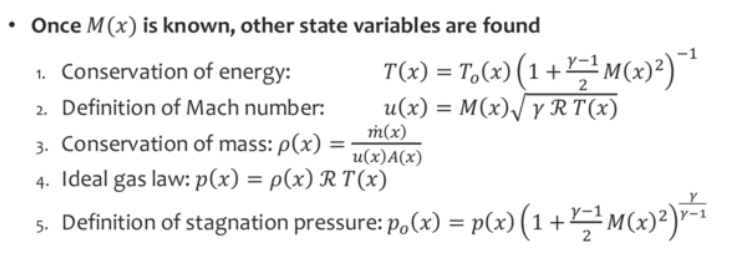

$$
= \frac{d}{dx} \left[ -2\frac{x-3}{2[1+0.25(x-3)^2]} + (1.4)\frac{0.04}{\sqrt{1+0.25(x-3)^2}} + (2.4)\frac{10}{1000 + 10x} \right]
$$

$$
= \frac{4 \left(x^{2} - 6x + 5\right)}{\left(x^{2} - 6x + 13\right)^{2}} -\frac{7 \left(x - 3\right)}{500 \left(\frac{\left(x - 3\right)^{2}}{4} + 1\right)^{3/2}} -\frac{240}{\left(10x + 1000\right)^{2}}
$$

The idea here is to use the near-sonic-point expression whenever within some tolerance $\epsilon$ of the sonic point, and otherwise, use the general 1D equation elsewhere.

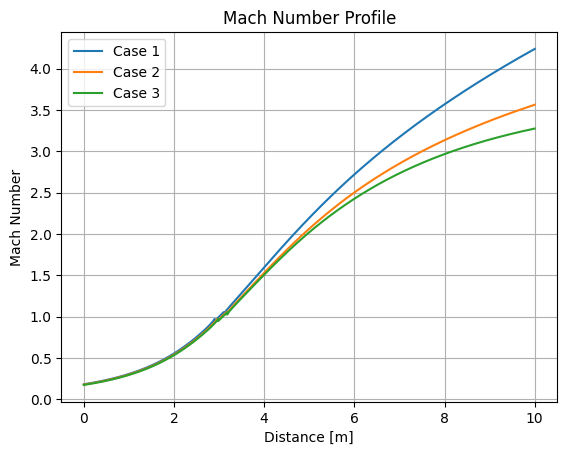

In [61]:
from scipy.integrate import solve_ivp

def get_M_profile_with_sonic(B, C, sonic_x, gamma):
    def dMdx_hodge(x, y, get_pos_root=True):
        """The expression for dM/dx near the sonic point in Hodge paper"""
        friction = (0.04/np.sqrt(1 + 0.25 * ((x-3)**2)))  # 4f/D
        heat = (10/(1000 + (10*x)))  # 1/T0 dT0/dx
        b = 2*gamma*((gamma+1)/8) * (B*friction + C*heat)
        area_deriv = (4 * (x**2 - 6 * x + 5))/(x**2 - 6 * x + 13)**2
        G_deriv = area_deriv + B * (-(7 * (x-3))/(500 * (((x-3)**2)/4 + 1)**(3/2))) + C * (-240 / (10 * x + 1000)**2)
        c = ((gamma+1)/8) * G_deriv
        if get_pos_root:
            return (-b + np.sqrt(b**2 - 4*c)) / 2
        return (-b + np.sqrt(b**2 - 4*c)) / 2

    def dM2dx(x, y):
        """General (Eq. 1) dM/dx expression from Hodge paper"""
        M = np.sqrt(y[0])
        G = (
            -2 * (x - 3) / (2 * (1 + 0.25 * (x - 3)**2))
            + B * gamma * M**2 * (0.04 / np.sqrt(1 + 0.25 * (x - 3)**2))
            + C * (1 + gamma * M**2) * (10 / (1000 + 10 * x))
        )
        psi = 1+((gamma - 1) / 2) * M**2
        return (psi * M**2)/(1-M**2) * G
    # Now, integrate backwards from sonic point to get M profile
    # Compute the solution, first near the sonic point
    eps = 1e-1
    pre_soln_delta = solve_ivp(dMdx_hodge, (sonic_x, sonic_x-eps), [1], args=(True,))
    post_soln_delta = solve_ivp(dMdx_hodge, (sonic_x, sonic_x+eps), [1], args=(True,))
    # Now, the general form away from the sonic point
    n_points = 1000
    x_vals = np.concatenate((np.linspace(0, sonic_x-eps, int(n_points*0.3)), np.linspace(sonic_x+eps, 10, int(n_points*0.7))))
    idx = np.argmax(x_vals >= sonic_x)
    pre_sonic_x = x_vals[:idx][::-1]
    post_sonic_x = x_vals[idx:]
    pre_soln = solve_ivp(dM2dx, (sonic_x-eps, 0), [pre_soln_delta.y[0][-1]], t_eval=pre_sonic_x)
    post_soln = solve_ivp(dM2dx, (sonic_x+eps, 10), [post_soln_delta.y[0][-1]], t_eval=post_sonic_x)
    x_profile = np.concatenate((pre_soln.t[::-1], pre_soln_delta.t[::-1],
                                post_soln_delta.t, post_soln.t))
    M_profile = np.concatenate((np.sqrt(pre_soln.y[0][::-1]), pre_soln_delta.y[0][::-1],
                                        post_soln_delta.y[0], np.sqrt(post_soln.y[0])))
    return x_profile, M_profile

x_profile_1, M_profile_1 = get_M_profile_with_sonic(B=0, C=0, sonic_x=case_1_sonic, gamma=1.4)
x_profile_2, M_profile_2 = get_M_profile_with_sonic(B=1, C=0, sonic_x=case_2_sonic, gamma=1.4)
x_profile_3, M_profile_3 = get_M_profile_with_sonic(B=1, C=1, sonic_x=case_3_sonic, gamma=1.4)
plt.figure()
plt.plot(x_profile_1, M_profile_1, label='Case 1', linewidth=1.5)
plt.plot(x_profile_2, M_profile_2, label='Case 2', linewidth=1.5)
plt.plot(x_profile_3, M_profile_3, label='Case 3', linewidth=1.5)
plt.xlabel('Distance [m]')
plt.ylabel('Mach Number')
plt.title('Mach Number Profile')
plt.grid(True)
plt.legend()
plt.show()


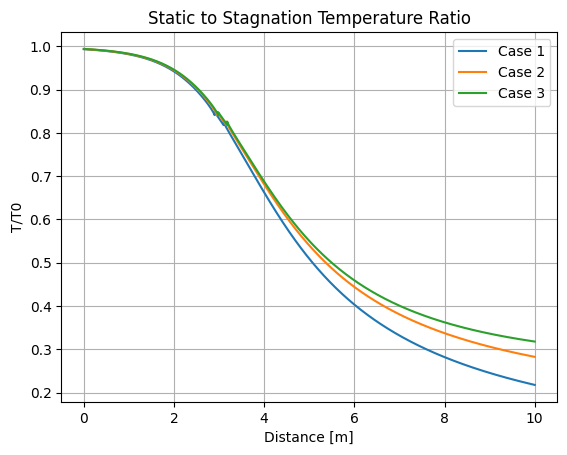

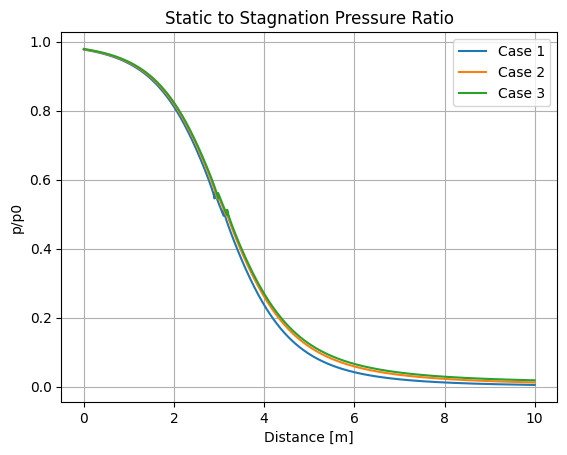

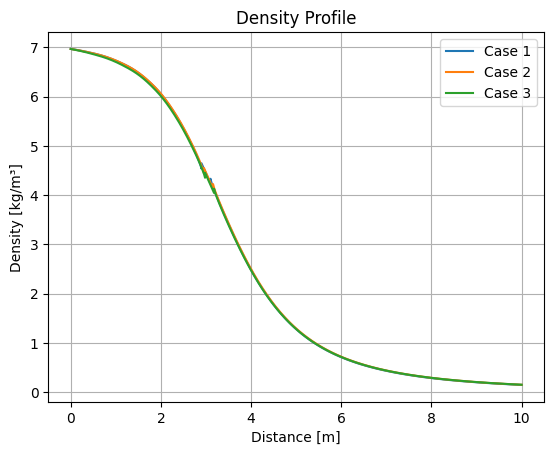

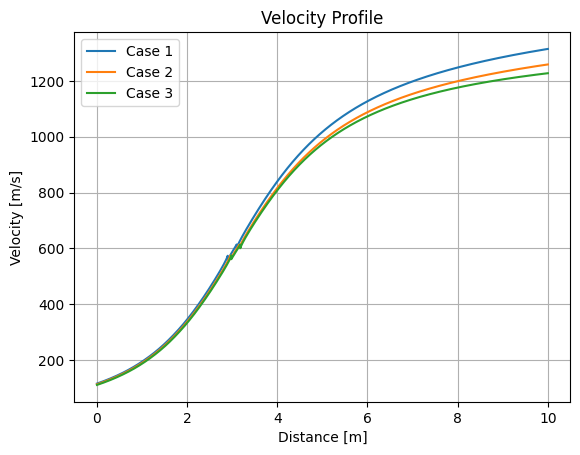

In [62]:
def A(x): return (np.pi / 4) * (1 + 0.25 * (x - 3)**2)

def get_properties(x, M_profile, gamma=1.4):
    T0_init, p0_init = 1000, 2e6
    rho0_init = p0_init / (287 * T0_init)
    T0_x = 1000 + 10 * x
    T_x = T0_x / (1 + ((gamma - 1) / 2) * M_profile**2)
    u_x = M_profile * np.sqrt(gamma * 287 * T_x)
    m_dot_const = rho0_init * A(0) * u_x[0]
    rho_x = m_dot_const / (A(x) * u_x)
    p_x = rho_x * 287 * T_x
    p0_x = p_x * (1 + ((gamma - 1) / 2) * M_profile**2)**(gamma/(gamma-1))
    return T_x, T0_x, p_x, p0_x, rho_x, u_x

T_profile_1, T0_profile_1, p_profile_1, p0_profile_1, rho_profile_1, u_profile_1 = get_properties(x_profile_1, M_profile_1)
T_profile_2, T0_profile_2, p_profile_2, p0_profile_2, rho_profile_2, u_profile_2 = get_properties(x_profile_2, M_profile_2)
T_profile_3, T0_profile_3, p_profile_3, p0_profile_3, rho_profile_3, u_profile_3 = get_properties(x_profile_3, M_profile_3)

plt.figure()
plt.plot(x_profile_1, T_profile_1/T0_profile_1, label='Case 1', linewidth=1.5)
plt.plot(x_profile_2, T_profile_2/T0_profile_2, label='Case 2', linewidth=1.5)
plt.plot(x_profile_3, T_profile_3/T0_profile_3, label='Case 3', linewidth=1.5)
plt.xlabel('Distance [m]')
plt.ylabel('T/T0')
plt.title('Static to Stagnation Temperature Ratio')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(x_profile_1, p_profile_1/p0_profile_1, label='Case 1', linewidth=1.5)
plt.plot(x_profile_2, p_profile_2/p0_profile_2, label='Case 2', linewidth=1.5)
plt.plot(x_profile_3, p_profile_3/p0_profile_3, label='Case 3', linewidth=1.5)
plt.xlabel('Distance [m]')
plt.ylabel('p/p0')
plt.title('Static to Stagnation Pressure Ratio')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(x_profile_1, rho_profile_1, label='Case 1', linewidth=1.5)
plt.plot(x_profile_2, rho_profile_2, label='Case 2', linewidth=1.5)
plt.plot(x_profile_3, rho_profile_3, label='Case 3', linewidth=1.5)
plt.xlabel('Distance [m]')
plt.ylabel('Density [kg/m³]')
plt.title('Density Profile')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(x_profile_1, u_profile_1, label='Case 1', linewidth=1.5)
plt.plot(x_profile_2, u_profile_2, label='Case 2', linewidth=1.5)
plt.plot(x_profile_3, u_profile_3, label='Case 3', linewidth=1.5)
plt.xlabel('Distance [m]')
plt.ylabel('Velocity [m/s]')
plt.title('Velocity Profile')
plt.grid(True)
plt.legend()
plt.show()


### Part (c)
Unfortunately I did not have time to complete this problem, but in words this is how I would approach it:

To determine whether a normal shock appears inside the nozzle, I first check whether the flow becomes choked. I would do this by assuming a fully subsonic isentropic solution and using the backpressure to infer the exit Mach and then the implied throat Mach. If this throat Mach is below one the flow stays subsonic and no shock can occur. If the implied throat Mach exceeds one the nozzle chokes, the throat Mach fixes at one, and the diverging section contains a supersonic region. Only in this regime can a normal shock form.

Next I would compute the purely isentropic supersonic solution from the throat to the exit. This gives me the isentropic exit pressure. I compare this value with the imposed backpressure. If the two match there is no shock. If the backpressure is lower than the isentropic result the flow remains fully supersonic inside and the compression occurs outside. If the backpressure is higher a normal shock is required somewhere in the diverging part to raise the static pressure.

If a shock is needed I would examine whether it can actually reside inside the nozzle. I treat the shock position as a free variable. For any trial location I compute the upstream Mach isentropically from the throat, apply the normal shock relations, then integrate the downstream subsonic branch to the exit and obtain the exit pressure. By sliding this trial shock forward and backward I generate a range of possible exit pressures. If the imposed backpressure falls within this range then a shock can sit inside the nozzle; if not the shock must lie either at the exit or outside the nozzle.

To find the exact location I would solve a one dimensional matching condition. I search over shock positions in the diverging region. For each trial position I compute the upstream state, apply the shock jump, compute the downstream isentropic exit pressure, and compare it with the imposed backpressure. If the predicted exit pressure is too high I move the trial shock downstream; if too low I move it upstream. Using a bracketing or bisection approach I adjust the shock position until the computed exit pressure matches the backpressure. This x coordinate is the predicted shock position.

The thrust is then computed by the velocity at the exit, and the constant mass flow rate we know from the inlet. 

### Part (d)
Once again, conceptually, for the lowest backpressure:

- Case 1
The flow is most efficient. Geometry alone accelerates the flow. That means for a given backpressure the inlet Mach required to support a normal shock in the diverging section (including right at the outlet) is the lowest here.

- Case 2
Friction eats away at stagnation pressure and tends to soften the supersonic region. To still produce a shock in the divergent part at the same backpressure, I have to start with a higher inlet Mach than in case 1 so that enough kinetic energy is available despite the losses.

- Case 3
Both friction and heating push the flow toward higher static pressure. So for the same backpressure, if an internal normal shock exists at all, it corresponds to the highest inlet Mach of the three.

### Part (e)
As mentioned above, since for increasing case number there are more losses, it depends on how we frame the problem but generally the higher the case the more lossy. So for the same inlet pressure, we get the highest thrust at 1 and lowest thrust at 3 (with potentially huge thrust loss if we have a shock inside the nozzle). For a fixed backpressure, we know that 3 needs the highest energy (and therefore inlet Mach number) to support the same backpressure. **However, we can look at the extreme case where a perfectly expanded shockless nozzle (a version of Case 1) can have much higher thrust even if comparatively Case 3 has the exact same inlet and outlet conditions but instead exhibits a shock such that the exit is subsonic and matches the backpressure conditions.**
